**APPENDIX D**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import random
 
import statsmodels.api as sm
 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
 
# Import Keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM
 
# Import Prophet
from fbprophet import Prophet
# Import VAR Model
from statsmodels.tsa.vector_ar.var_model import VAR
 
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('Aotizhongxin1 - Copy (3) - Copy.csv')
df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,4.4
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,4.7
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,5.6
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,3.1
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,2.0


In [ ]:
df['date'] = df[['year', 'month', 'day', 'hour']].apply(lambda row: f"{row['year']}-{row['month']}-{row['day']} {row['hour']}:00:00", axis=1)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,date
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,4.4,2013-03-01 00:00:00
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,4.7,2013-03-01 01:00:00
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,5.6,2013-03-01 02:00:00
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,3.1,2013-03-01 03:00:00
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,2.0,2013-03-01 04:00:00


In [ ]:

df.drop(['No','year','month','day','hour'], axis=1, inplace=True)
df.head()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,date
0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,4.4,2013-03-01 00:00:00
1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,4.7,2013-03-01 01:00:00
2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,5.6,2013-03-01 02:00:00
3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,3.1,2013-03-01 03:00:00
4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,2.0,2013-03-01 04:00:00


In [ ]:
df.sort_values(by='date', inplace=True)
df.head()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,date
0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,4.4,2013-03-01 00:00:00
1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,4.7,2013-03-01 01:00:00
2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,5.6,2013-03-01 02:00:00
3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,3.1,2013-03-01 03:00:00
4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,2.0,2013-03-01 04:00:00


In [ ]:
df['date'].min(), df['date'].max()

(Timestamp('2013-03-01 00:00:00'), Timestamp('2017-02-28 23:00:00'))

In [ ]:
df.set_index('date', inplace=True)
df.head()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
date,,,,,,,,,,,
2013-03-01 00:00:00,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,4.4
2013-03-01 01:00:00,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,4.7
2013-03-01 02:00:00,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,5.6
2013-03-01 03:00:00,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,3.1
2013-03-01 04:00:00,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,2.0


In [ ]:
# Data grouped Month-wise
grpd_df = df.resample('MS').mean()
print(grpd_df.shape)
grpd_df.head()

(48, 11)


,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
date,,,,,,,,,,,
2013-03-01,110.092742,144.147849,44.834608,74.769694,1470.720878,46.841454,6.053629,1012.547446,-5.729435,0.026210,2.000134
2013-04-01,62.751389,108.204167,24.733914,53.789352,921.192593,51.505010,12.260694,1008.296944,-1.553611,0.015139,2.209722
2013-05-01,85.090502,140.778226,30.442204,61.016129,933.239695,75.590768,21.374194,1003.162231,9.790457,0.007796,1.740457
2013-06-01,106.179167,128.716667,14.474761,72.698583,1240.300463,71.235024,23.386111,1000.165556,18.009028,0.130694,1.240000
2013-07-01,68.911290,85.391129,9.284144,55.137308,818.043907,71.914410,26.877419,996.033065,21.459946,0.293817,1.278763


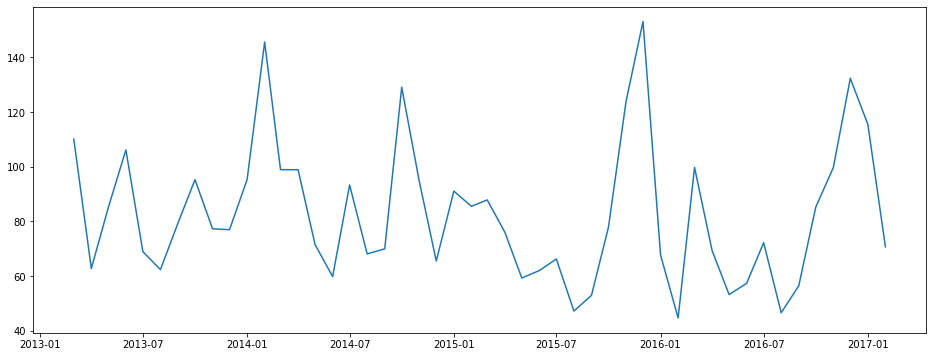

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(grpd_df['PM2.5'].dropna())
plt.show()

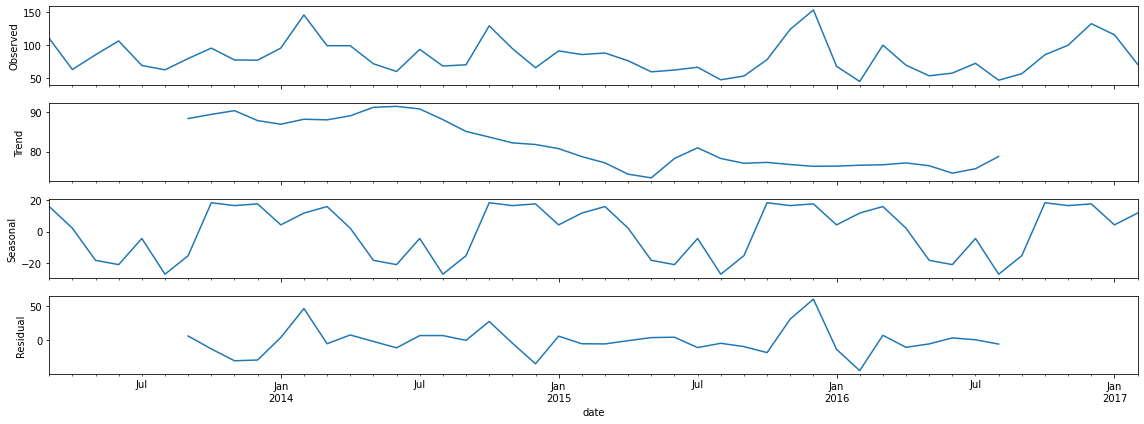

<Figure size 1152x432 with 0 Axes>

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 16, 6

# Decomposing the data to check for Trends, Seasonality and Noise.
decomposition = sm.tsa.seasonal_decompose(grpd_df['PM2.5'])
fig = decomposition.plot()
plt.figure(figsize=(16,6))
plt.show()

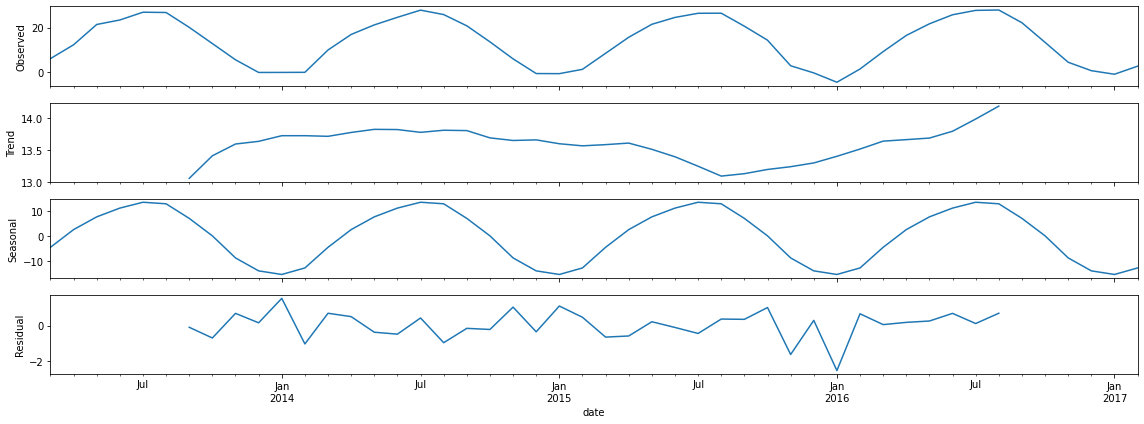

In [ ]:

# Decomposing the data to check for Trends, Seasonality and Noise.
decomposition = sm.tsa.seasonal_decompose(grpd_df['TEMP'])
fig = decomposition.plot()
plt.show()

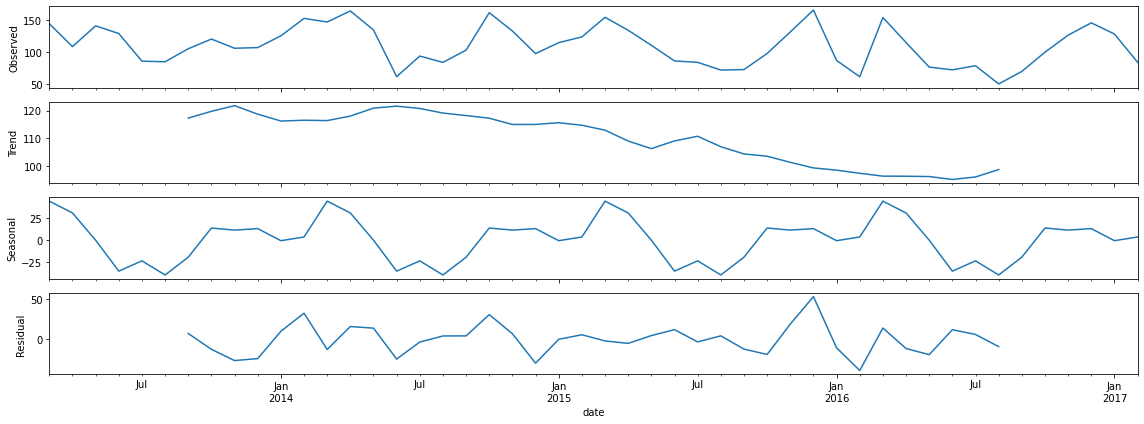

In [ ]:

# Decomposing the data to check for Trends, Seasonality and Noise.
decomposition = sm.tsa.seasonal_decompose(grpd_df['PM10'])
fig = decomposition.plot()
plt.show()

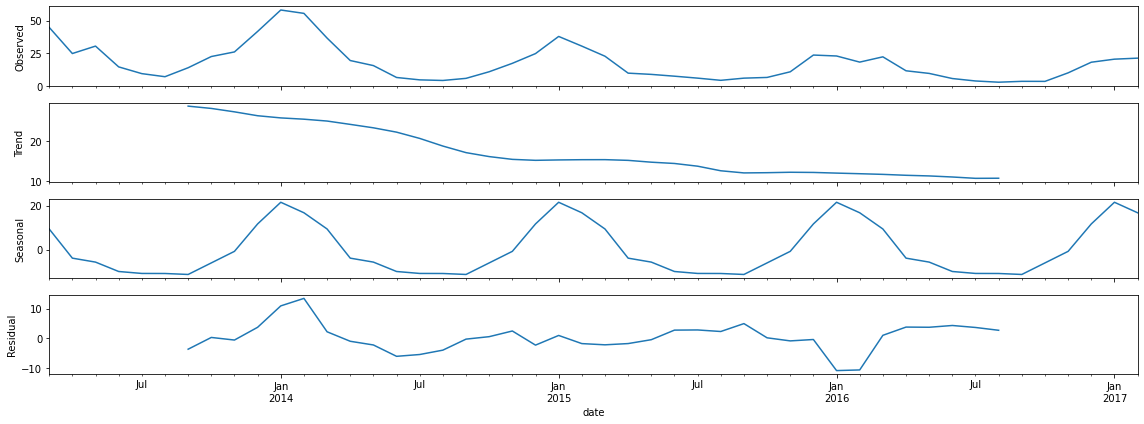

In [ ]:

# Decomposing the data to check for Trends, Seasonality and Noise.
decomposition = sm.tsa.seasonal_decompose(grpd_df['SO2'])
fig = decomposition.plot()
plt.show()

In [ ]:
df['2013-03-01']['PM2.5'].mean()

7.125

In [ ]:
df['PM2.5'].fillna(method='ffill', inplace=True)
df['PM2.5'].fillna(value=df['2013-03-01']['PM2.5'].mean(), inplace=True)
df.head()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
date,,,,,,,,,,,
2013-03-01 00:00:00,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,4.4
2013-03-01 01:00:00,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,4.7
2013-03-01 02:00:00,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,5.6
2013-03-01 03:00:00,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,3.1
2013-03-01 04:00:00,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,2.0


In [ ]:
df = df.resample('D').mean()

# Split data into train and validation set
train = df[:int(0.7*(len(df)))]
valid = df[int(0.7*(len(df))):]

In [ ]:
sc = StandardScaler()
sc.fit(train)
train = pd.DataFrame(sc.transform(train), columns=df.columns, index=train.index)
valid = pd.DataFrame(sc.transform(valid), columns=df.columns, index=valid.index)

In [ ]:
model = sm.tsa.VARMAX(train, order=(5, 0), trend='c')
model_result = model.fit(maxiter=5, disp=False)
model_result.summary()

Processing Parameters - i: "1" and trend: "c"
Order =  1
AIC:  12750.26417604998
BIC:  13726.308496661182
HQIC:  13120.837048015901
===> Time Taken: 0:00:20.719628
                                                            Statespace Model Results                                                           
Dep. Variable:     ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']   No. Observations:                 1022
Model:                                                                                          VAR(1)   Log Likelihood               -6177.132
                                                                                           + intercept   AIC                          12750.264
Date:                                                                                 Sat, 01 May 2021   BIC                          13726.308
Time:                                                                                         14:00:31   HQIC       

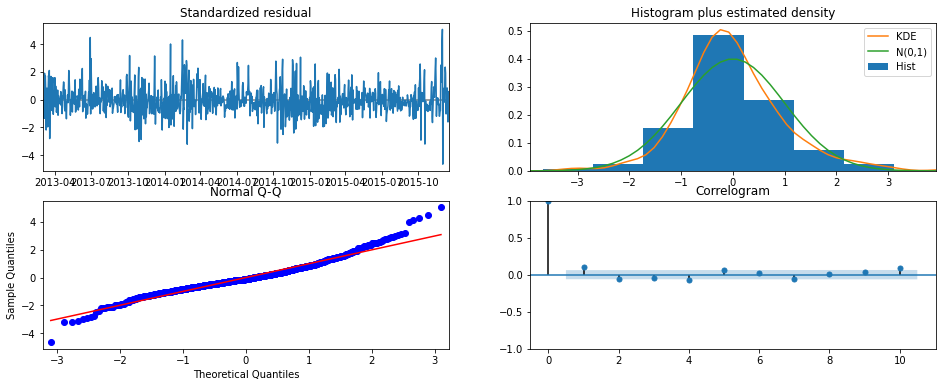

Processing Parameters - i: "2" and trend: "ct"
Order =  2
AIC:  12485.113182042513
BIC:  14111.853716394517
HQIC:  13102.734635319048
===> Time Taken: 0:10:44.984828
                                                            Statespace Model Results                                                           
Dep. Variable:     ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']   No. Observations:                 1022
Model:                                                                                          VAR(2)   Log Likelihood               -5912.557
                                                                                           + intercept   AIC                          12485.113
Date:                                                                                 Sat, 01 May 2021   BIC                          14111.854
Time:                                                                                         14:11:16   HQIC     

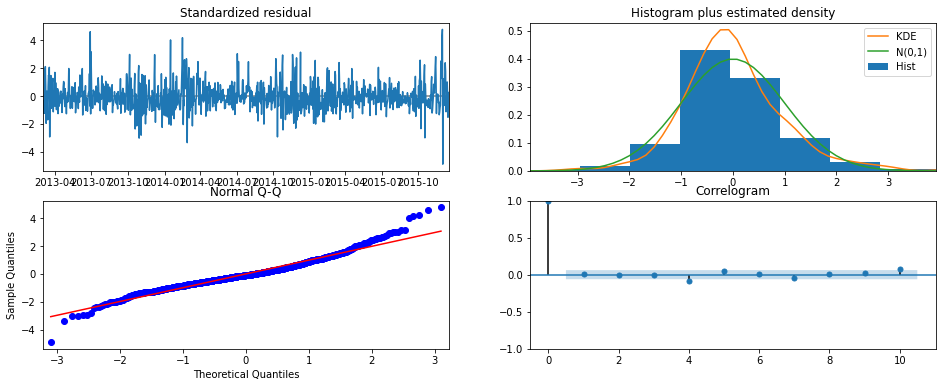

Processing Parameters - i: "3" and trend: "ct"
Order =  3
AIC:  12468.730645256715
BIC:  14691.942708871122
HQIC:  13312.81329806798
===> Time Taken: 0:10:36.480780
                                                            Statespace Model Results                                                           
Dep. Variable:     ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']   No. Observations:                 1022
Model:                                                                                          VAR(3)   Log Likelihood               -5783.365
                                                                                           + intercept   AIC                          12468.731
Date:                                                                                 Sat, 01 May 2021   BIC                          14691.943
Time:                                                                                         14:21:53   HQIC      

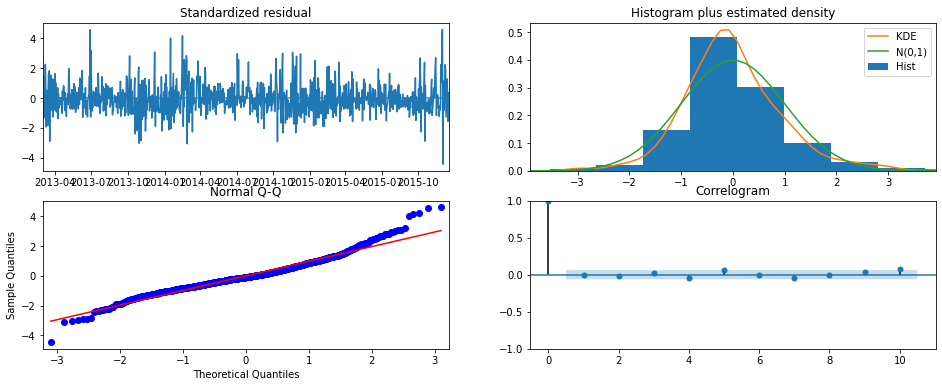

Processing Parameters - i: "4" and trend: "ct"
Order =  4
AIC:  12539.529894563708
BIC:  15359.213487440516
HQIC:  13610.073746909704
===> Time Taken: 0:37:36.041455
                                                            Statespace Model Results                                                           
Dep. Variable:     ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']   No. Observations:                 1022
Model:                                                                                          VAR(4)   Log Likelihood               -5697.765
                                                                                           + intercept   AIC                          12539.530
Date:                                                                                 Sat, 01 May 2021   BIC                          15359.213
Time:                                                                                         14:59:30   HQIC     

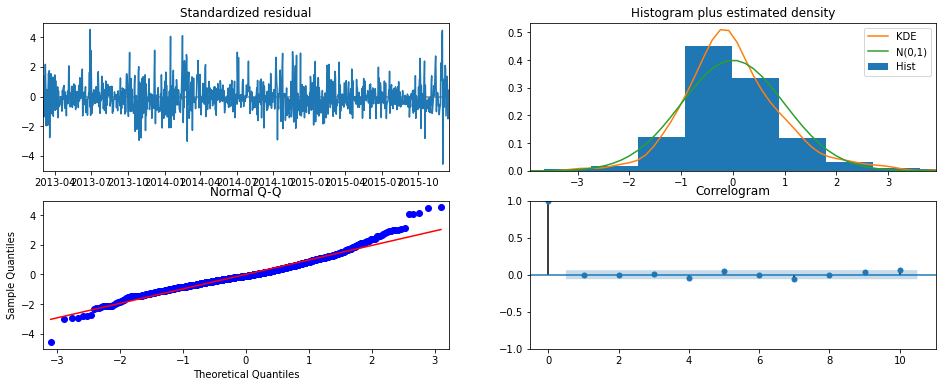

Processing Parameters - i: "5" and trend: "t"
Order =  5
AIC:  12606.092211141917
BIC:  15968.022648802726
HQIC:  13882.509881246757
===> Time Taken: 1:04:12.976309
                                                            Statespace Model Results                                                           
Dep. Variable:     ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']   No. Observations:                 1022
Model:                                                                                          VAR(5)   Log Likelihood               -5621.046
                                                                                           + intercept   AIC                          12606.092
Date:                                                                                 Sat, 01 May 2021   BIC                          15968.023
Time:                                                                                         16:03:44   HQIC      

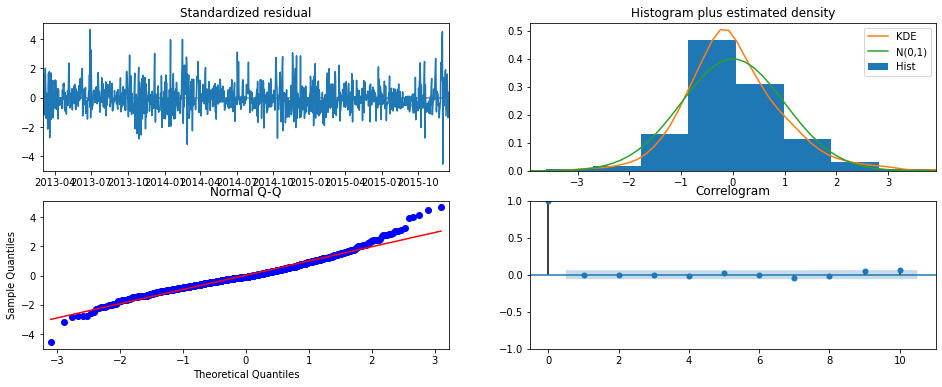

CPU times: user 1h 57min 43s, sys: 2h 6min 20s, total: 4h 4min 4s
Wall time: 2h 3min 35s


In [ ]:
%%time
trends=['n','c','t','ct']
for i in range(1,6):
    time_d = datetime.now()
    trend = random.choice(trends)
    
    print('='*80)
    print(f'Processing Parameters - i: "{i}" and trend: "{trend}"')
    
    model = sm.tsa.VARMAX(train, order=(i,0), trend=trend)
    model_result = model.fit(maxiter=5, disp=False)
    
    print('Order = ', i)
    print('AIC: ', model_result.aic)
    print('BIC: ', model_result.bic)
    print('HQIC: ', model_result.hqic)
    print(f'===> Time Taken: {datetime.now() - time_d}')
    print(model_result.summary())
    model_result.plot_diagnostics()
    plt.show()
    

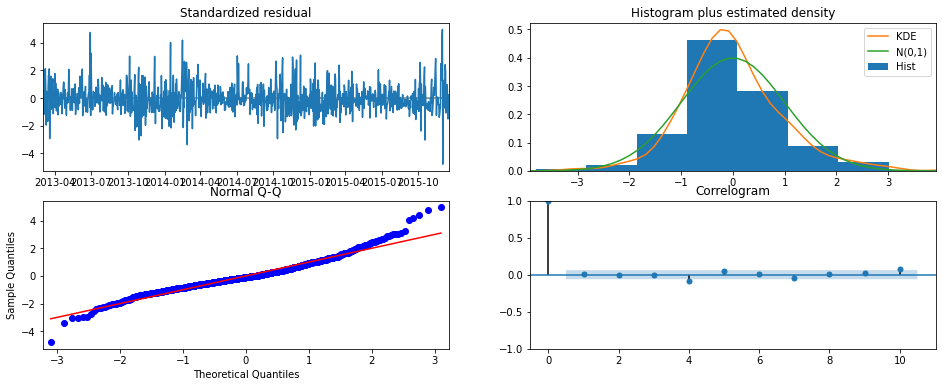

In [ ]:
model = sm.tsa.VARMAX(train, order=(2,0), trend=trend)
model_result = model.fit(maxiter=1000, disp=False)
model_result.plot_diagnostics()
plt.show()

In [ ]:
predictions = model_result.forecast(steps=len(valid))

In [ ]:
var_pred = pd.DataFrame(predictions, columns=df.columns)

#check rmse
for i in df.columns:
    print('RMSE value for', i, 'is : ', np.sqrt(mean_squared_error(var_pred[i], valid[i])))
    print('MSE value for', i, 'is : ', mean_squared_error(var_pred[i], valid[i]))
    print('RMSE value for', i, 'is : ', mean_absolute_error(var_pred[i], valid[i]))

RMSE value for PM2.5 is :  1.1584501687923145
MSE value for PM2.5 is :  1.342006793574942
RMSE value for PM2.5 is :  0.8712834160451965
RMSE value for PM10 is :  1.1187541271755375
MSE value for PM10 is :  1.2516107970722985
RMSE value for PM10 is :  0.8963854456867606
RMSE value for SO2 is :  0.832009307091934
MSE value for SO2 is :  0.6922394870876002
RMSE value for SO2 is :  0.7485376180565783
RMSE value for NO2 is :  1.25315051999824
MSE value for NO2 is :  1.5703862257718595
RMSE value for NO2 is :  1.0756947089035234
RMSE value for CO is :  1.4405582317564527
MSE value for CO is :  2.075208019081278
RMSE value for CO is :  1.1300134417640613
RMSE value for O3 is :  1.1447378702597604
MSE value for O3 is :  1.3104247916068519
RMSE value for O3 is :  0.8929605832354068
RMSE value for TEMP is :  1.258040532447036
MSE value for TEMP is :  1.5826659812796222
RMSE value for TEMP is :  1.0239323590446954
RMSE value for PRES is :  1.1368297961600762
MSE value for PRES is :  1.29238198543

In [ ]:
model = VAR(endog=df.values)
model_fit = model.fit()
yhat = model_fit.forecast(model_fit.y, steps=1)
print(yhat)

[[ 5.91269473e+01  9.14500613e+01  2.32044285e+01  5.79147424e+01
   1.10105700e+03  7.23954764e+01  1.05911392e+01  1.01366090e+03
  -7.60526420e+00 -2.85787232e-02  1.81758661e+00]]


In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 16, 6

def plot_pred_date(pred):
    pred = pd.DataFrame(sc.inverse_transform(pred), columns=df.columns, index=valid.index)
    temp = pd.DataFrame(sc.inverse_transform(train), columns=train.columns, index=train.index)
    
    for col in temp.columns:
        plt.plot(temp[col], 'r-', label='Actual Data')
        plt.plot(pred[col], 'b-', label='Predicted Data')
        plt.legend()
        plt.xlabel('Date')
        plt.ylabel(col)
        plt.title(f'Predicted {col} vs DateTime')
        plt.show()
        
    return


def plot_actual_pred(pred):
    pred = pd.DataFrame(sc.inverse_transform(pred), columns=df.columns, index=valid.index)
    temp = pd.DataFrame(sc.inverse_transform(valid), columns=valid.columns, index=valid.index)

    for col in temp.columns:
        plt.plot(temp[col], 'r-', label='Actual Data')
        plt.plot(pred[col], 'b-', label='Predicted Data')
        plt.legend()
        plt.xlabel('Date')
        plt.ylabel(col)
        plt.title(f'Actual {col} vs Predicted {col}')
        plt.show()
        
    return

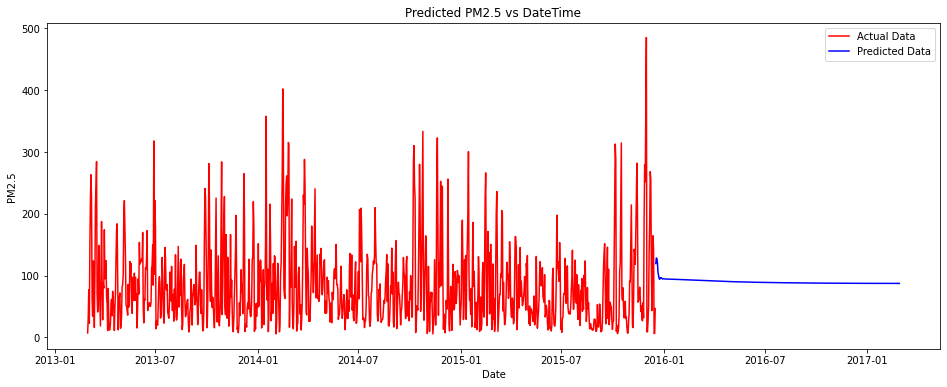

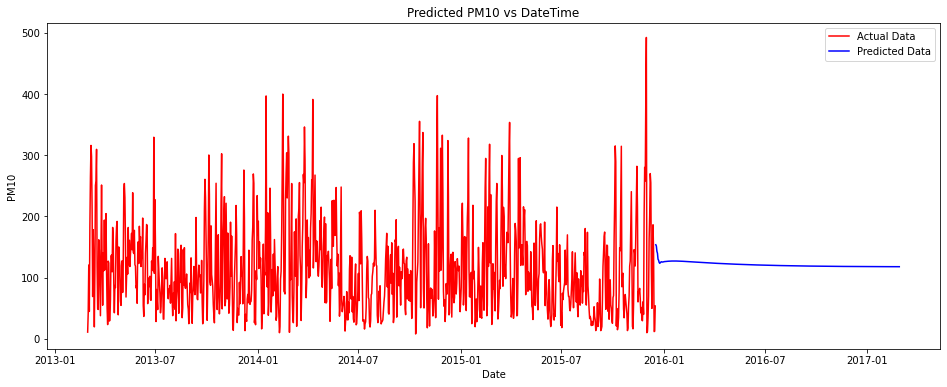

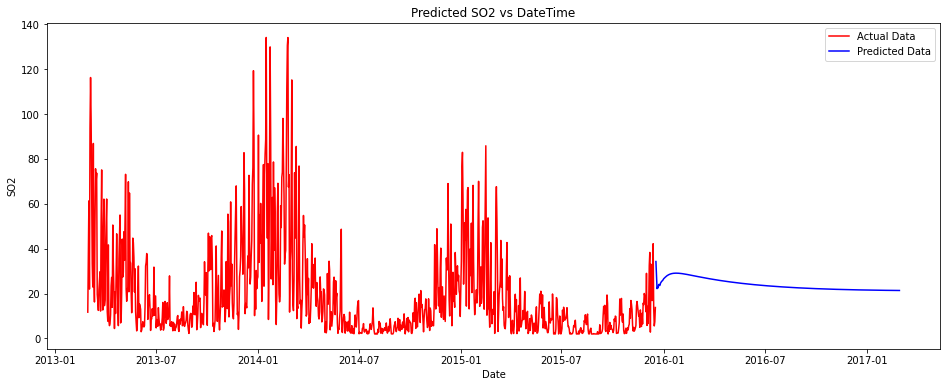

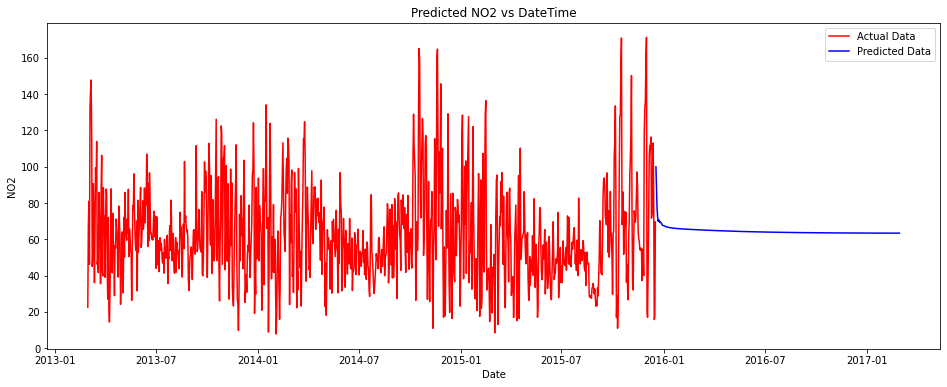

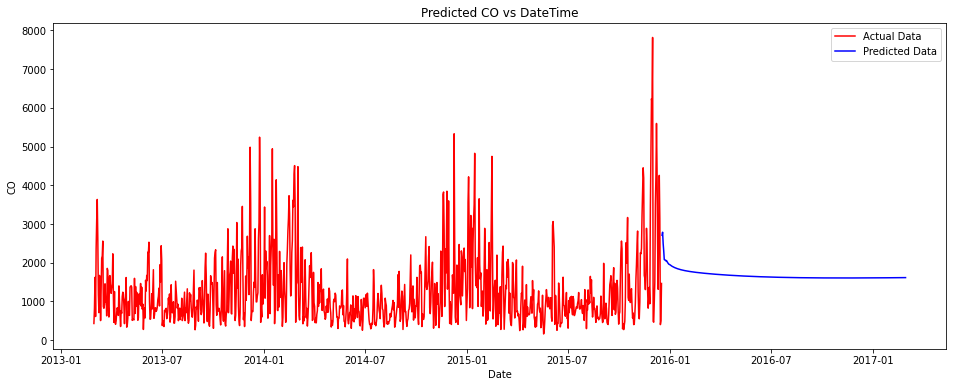

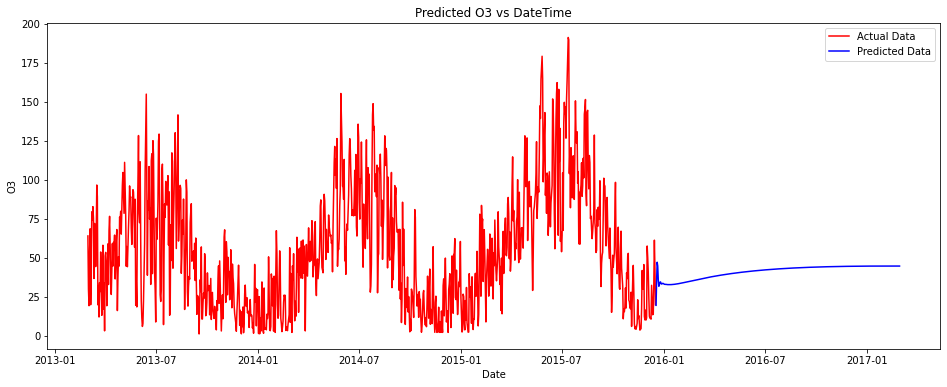

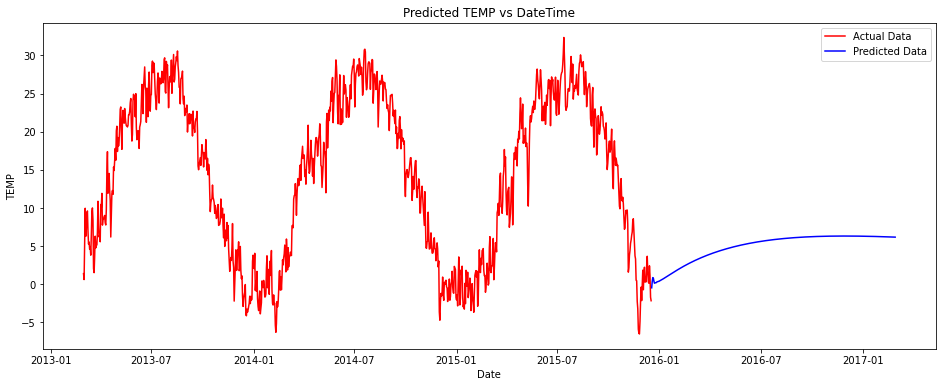

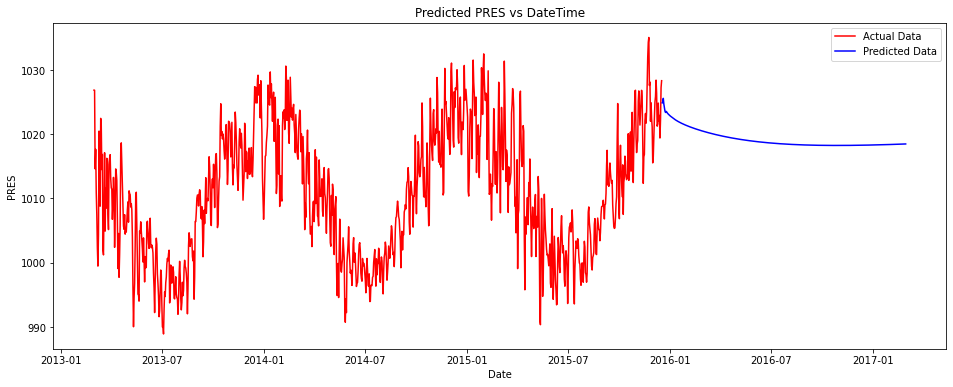

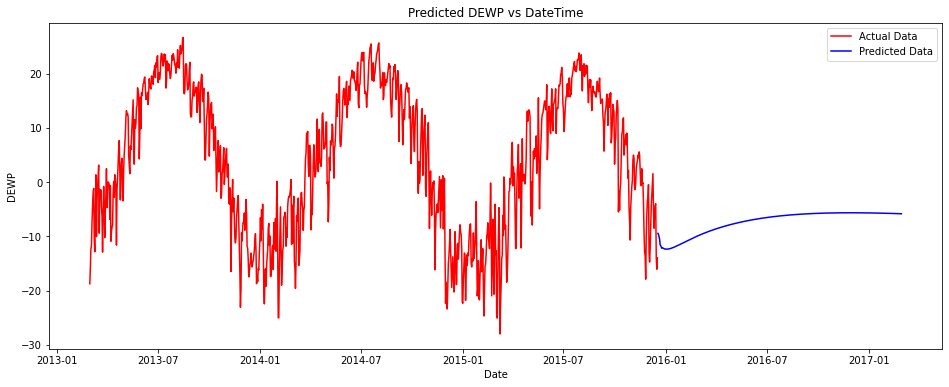

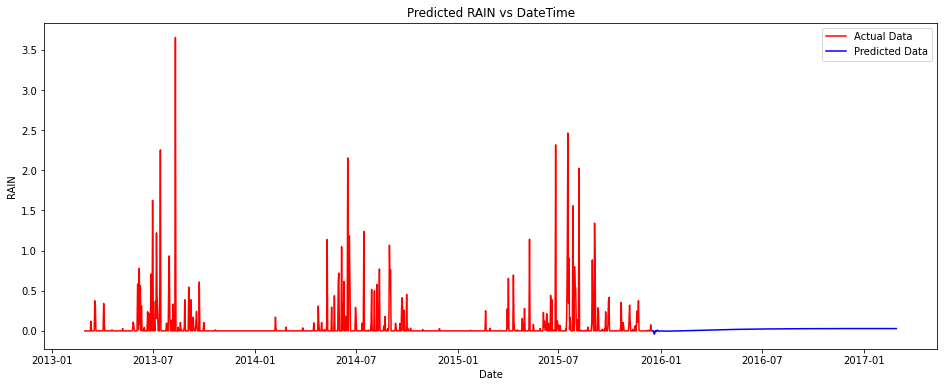

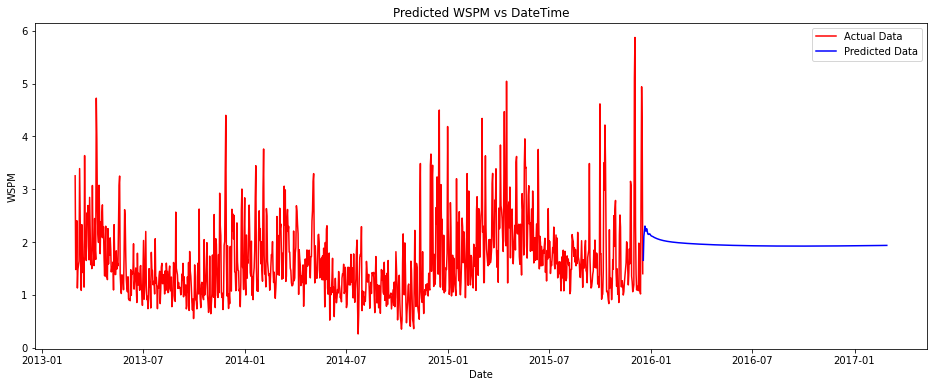

In [ ]:
plot_pred_date(var_pred)

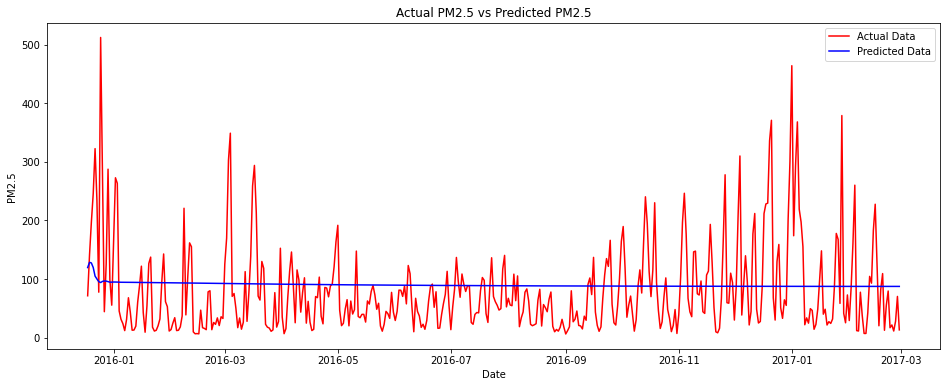

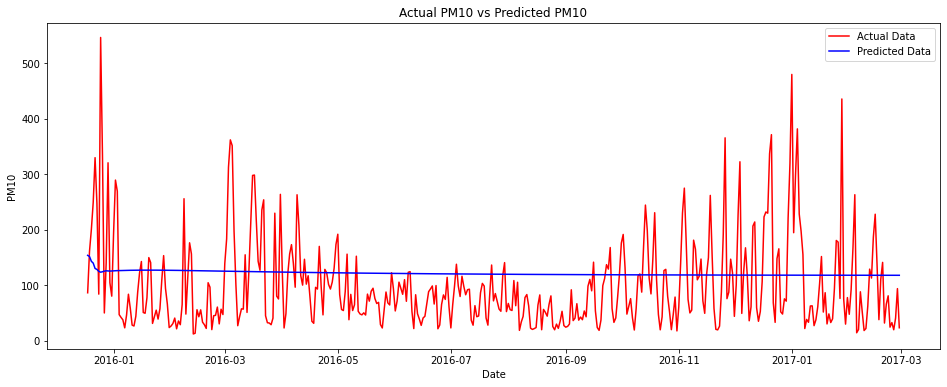

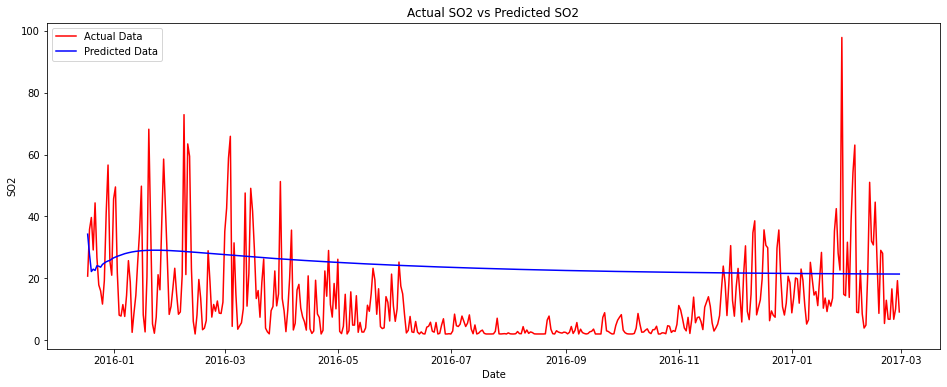

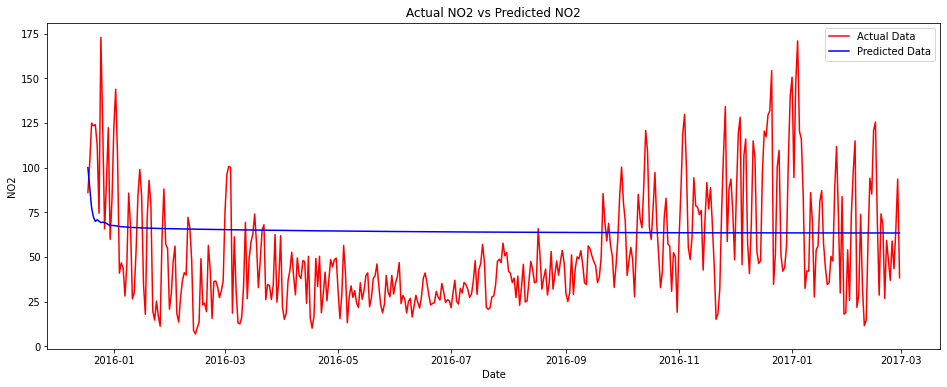

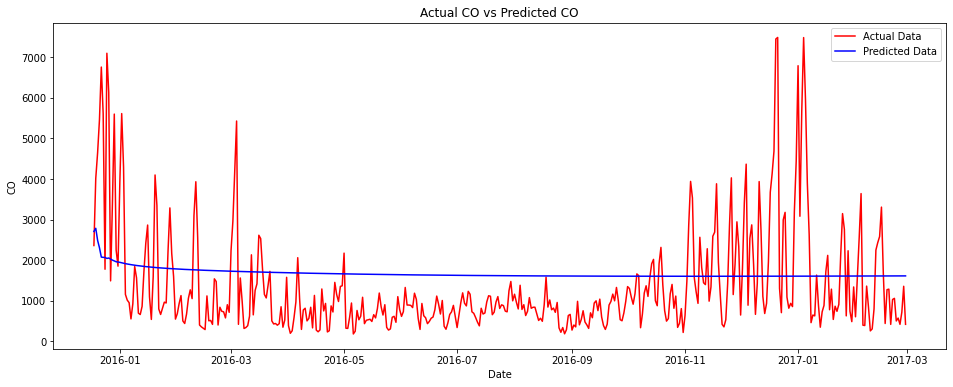

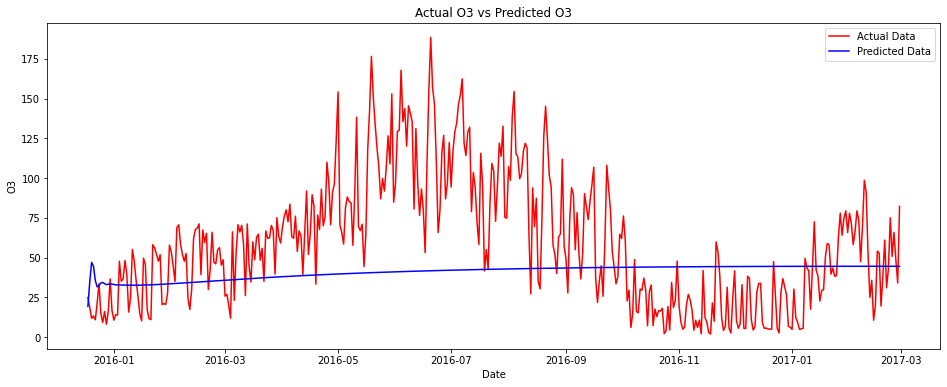

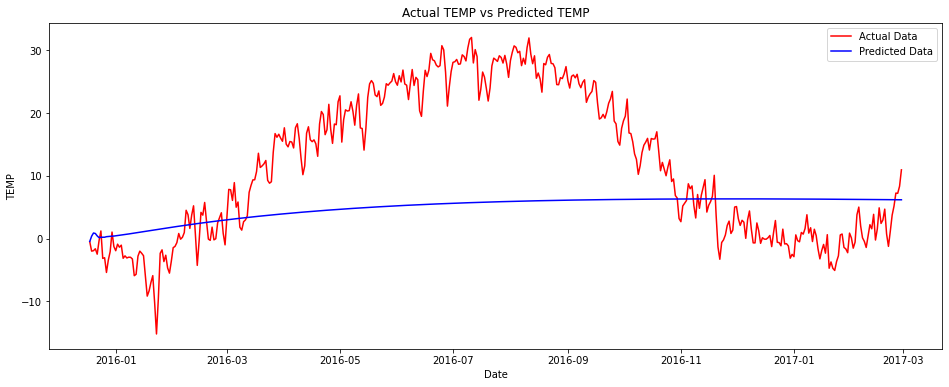

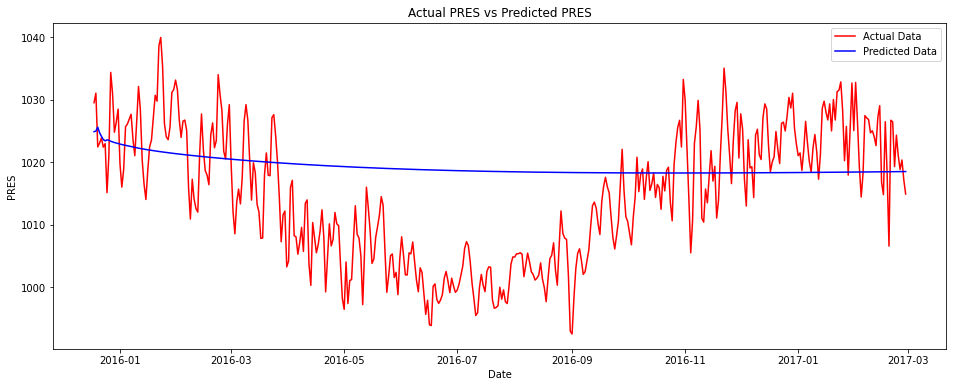

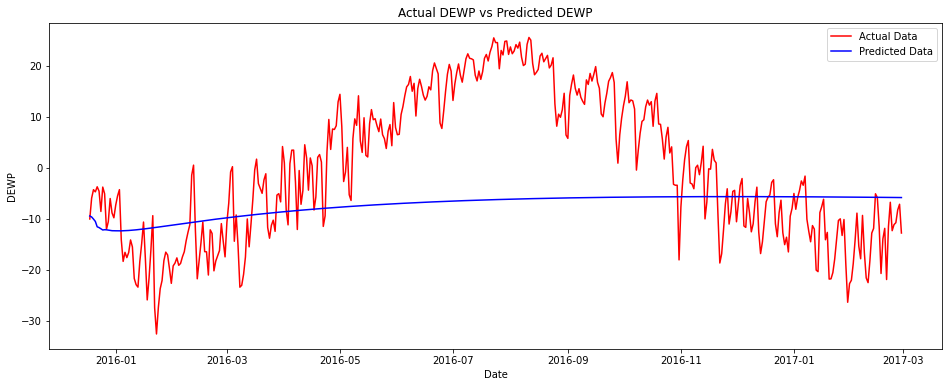

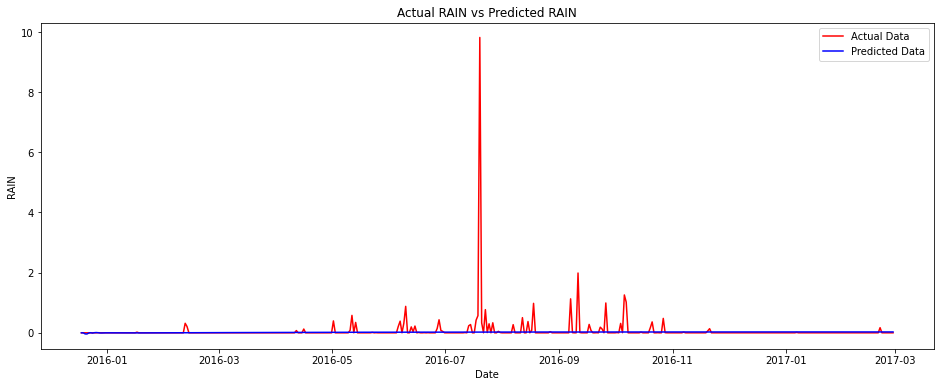

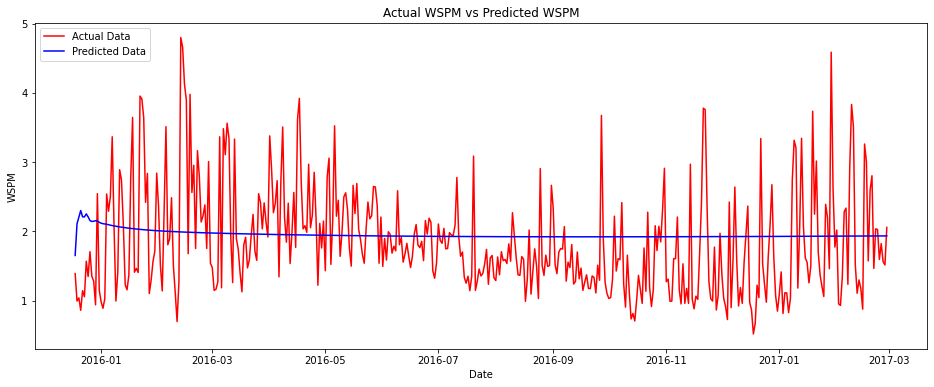

In [ ]:
plot_actual_pred(var_pred)